[*********************100%***********************]  1 of 1 completed


Sharpe Ratio: 0.88
Max Drawdown: 28.76%


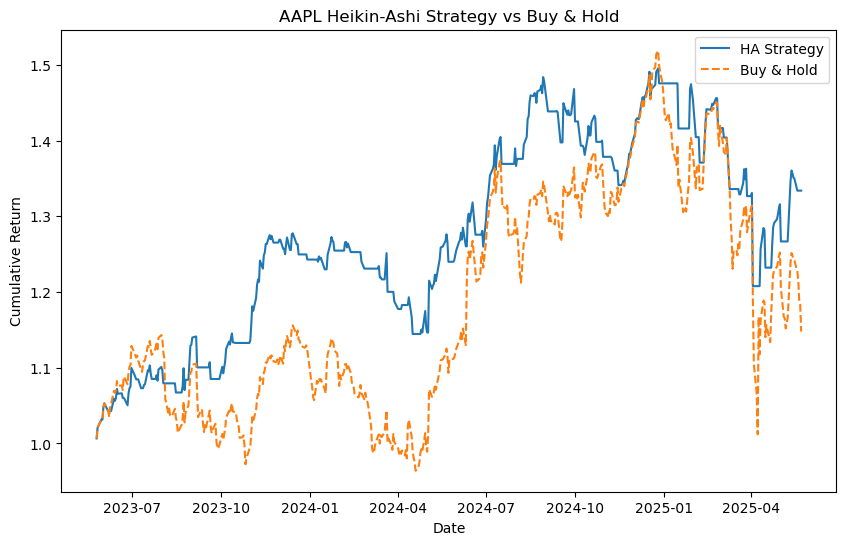

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration: set the ticker symbol and data parameters
ticker    = "AAPL"    # stock symbol to analyze
period    = "2y"      # lookback period of 2 years
interval  = "1d"      # daily data

# 2. Download price data and drop any missing values
df = yf.download(ticker, period=period, interval=interval).dropna()

# 3. Compute Heikin-Ashi candles
# 3.1 Calculate HA_Close as the average of Open, High, Low, Close
df['HA_Close'] = df[['Open', 'High', 'Low', 'Close']].sum(axis=1) / 4

# 3.2 Initialize the first HA_Open as the average of the first bar's Open and Close
first_ha_open = (df['Open'].iloc[0] + df['Close'].iloc[0]) / 2

# 3.3 Build a Series to iteratively calculate HA_Open for each bar
ha_open = pd.Series(index=df.index, dtype=float)
ha_open.iloc[0] = first_ha_open
for i in range(1, len(df)):
    # Each HA_Open is the average of the previous bar's HA_Open and HA_Close
    ha_open.iloc[i] = (ha_open.iloc[i-1] + df['HA_Close'].iloc[i-1]) / 2

# Assign the computed HA_Open back to the DataFrame
df['HA_Open'] = ha_open

# 3.4 Compute HA_High and HA_Low for each bar
# HA_High is the maximum of the original High, HA_Open, and HA_Close
df['HA_High'] = df[['High', 'HA_Open', 'HA_Close']].max(axis=1)
# HA_Low is the minimum of the original Low, HA_Open, and HA_Close
df['HA_Low']  = df[['Low', 'HA_Open', 'HA_Close']].min(axis=1)

# 4. Generate a simple trading signal: long whenever HA_Close > HA_Open
# Position = 1 means long; Position = 0 means flat
df['Position'] = np.where(df['HA_Close'] > df['HA_Open'], 1, 0)

# 5. Backtest: calculate daily returns based on the Position
# Multiply the previous day's position by today's price change
df['Return'] = (df['Close'].pct_change()).squeeze() * df['Position'].shift()

# Compute cumulative return series
cumulative_return = (1 + df['Return']).cumprod()

# Compute maximum drawdown: peak-to-trough decline
max_drawdown = (cumulative_return.cummax() - cumulative_return).max()

# Compute annualized Sharpe ratio (assuming 252 trading days)
sharpe_ratio = df['Return'].mean() / df['Return'].std() * np.sqrt(252)

# Print performance metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# 6. Visualization: compare strategy vs. buy-and-hold
plt.figure(figsize=(10, 6))
# Plot the strategy's cumulative return
plt.plot(cumulative_return, label='HA Strategy')

# Calculate and plot buy-and-hold cumulative return for benchmark
buy_hold = (1 + df['Close'].pct_change()).cumprod()
plt.plot(buy_hold, '--', label='Buy & Hold')

# Add chart annotations
plt.title(f"{ticker} Heikin-Ashi Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()
